# WP1 - Anomaly subgraph extraction: Finding anomalies

In [1]:
import py2neo
import pandas as pd
import numpy as np
from spot import bidSPOT, dSPOT,  SPOT
import traceback
import networkx as nx
from datetime import datetime, timedelta

In [2]:
graph = nx.read_graphml("../data/causality_chi2.graphml")
graph = graph.to_undirected()

/Users/lisa/opt/anaconda3/envs/graphs_ml/lib/python3.9/site-packages/networkx/readwrite/graphml.py:1032: UserWarning: No key type for id id. Using string
  warnings.warn(f"No key type for id {attr_id}. Using string")
/Users/lisa/opt/anaconda3/envs/graphs_ml/lib/python3.9/site-packages/networkx/readwrite/graphml.py:1032: UserWarning: No key type for id labels. Using string
  warnings.warn(f"No key type for id {attr_id}. Using string")
/Users/lisa/opt/anaconda3/envs/graphs_ml/lib/python3.9/site-packages/networkx/readwrite/graphml.py:1032: UserWarning: No key type for id causal. Using string
  warnings.warn(f"No key type for id {attr_id}. Using string")
/Users/lisa/opt/anaconda3/envs/graphs_ml/lib/python3.9/site-packages/networkx/readwrite/graphml.py:1032: UserWarning: No key type for id label. Using string
  warnings.warn(f"No key type for id {attr_id}. Using string")


In [3]:
full_data = pd.read_csv('../data/loadtest-timestamp.csv')
full_data[['Date', 'Time']] = full_data['Time'].str.split(" ", expand=True)
full_data = full_data.sort_values(by=['Date','Time'])
full_data

,Unnamed: 0,Time,carts,carts-db,catalogue,catalogue-db,front-end,orders,orders-db,payment,queue-master,rabbitmq,session-db,shipping,user,user-db,Date
674,674,11:27,0.00245,0.00824,0.00129,0.001150,0.00313,0.00260,0.00901,0.001250,0.00254,0.0145,0.00232,0.00223,0.00178,0.00942,10/14/2021
675,675,11:28,0.00279,0.01020,0.00128,0.001080,0.00352,0.00273,0.00974,0.001310,0.00249,0.0136,0.00268,0.00235,0.00191,0.01060,10/14/2021
676,676,11:29,0.00345,0.00929,0.00140,0.001180,0.00379,0.00262,0.00938,0.001370,0.00329,0.0132,0.00260,0.00214,0.00198,0.01020,10/14/2021
677,677,11:30,0.00233,0.00890,0.00108,0.001120,0.00343,0.00227,0.00783,0.001300,0.00239,0.0113,0.00223,0.00221,0.00173,0.00869,10/14/2021
678,678,11:31,0.00421,0.00914,0.00148,0.001380,0.00405,0.00297,0.00980,0.001410,0.00250,0.0127,0.00259,0.00234,0.00233,0.01030,10/14/2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
527,527,20:33,0.00312,0.01000,0.00139,0.000967,0.00300,0.00320,0.00924,0.001150,0.00214,0.0152,0.00238,0.00187,0.00234,0.00920,3/2/2022
528,528,20:34,0.00252,0.01080,0.00116,0.001060,0.00311,0.00259,0.01050,0.001480,0.00210,0.0118,0.00260,0.00220,0.00195,0.00965,3/2/2022
529,529,20:35,0.00311,0.01030,0.00134,0.001460,0.00366,0.00278,0.01060,0.001330,0.00222,0.0122,0.00247,0.00271,0.00237,0.01090,3/2/2022
530,530,20:36,0.00220,0.01030,0.00102,0.000994,0.00334,0.00458,0.00998,0.000969,0.00222,0.0128,0.00241,0.00213,0.00180,0.00955,3/2/2022


In [ ]:
# Prepare data
u_data = (full_data['Date'] == '2/17/2022')| (full_data['Date'] == '3/2/2022')
all_data = full_data[u_data]
# initial batch
u_init_data = (full_data['Date'] == '10/14/2021') | (full_data['Date'] == '10/20/2021')| (full_data['Date'] == '10/19/2021')
all_init_data = full_data[u_init_data]

csv_nodes = full_data.columns.drop(['Date', 'Time', 'Unnamed: 0'])
print("Node names from data csv: ", sorted(csv_nodes))
graph_nodes = [node[1]['id'] for node in graph.nodes.data()]
print("Node names from graph: ", sorted(graph_nodes))
print("Nodes in graph but not in data csv: ", sorted(set(graph_nodes) - set(csv_nodes)))
print("Nodes in data csv but not in graph: ", sorted(set(csv_nodes) - set(graph_nodes)))
for column_name in csv_nodes:
    init_data = all_init_data[column_name].to_numpy()
    data = all_data[column_name].to_numpy()

    try:
        q = 1e-5  			# risk parameter
        s = SPOT(q)  		# SPOT object
        s.fit(init_data,data) 	# data import
        s.initialize(verbose=False) 		# initialization step
        results = s.run() 	# run
        alarms = results["alarms"]
        print(column_name, alarms)
        node = [n for n in graph.nodes.data() if n[1]["id"] == column_name][0]
        if len(alarms) > 0:
            print(node)
            print("had an anomaly")
            print(full_data.iloc[alarms[0]])
            node[1]["anomaly"] = True
            #print(all_data.iloc[alarms][['Date', 'Time']])
            anomaly_timestamps = [" ".join(all_data.iloc[alarm][['Date', 'Time']]) for alarm in alarms]
            node[1]["anomaly_timestamps"] = anomaly_timestamps
        else:
            node[1]["anomaly"] = False
    except Exception:
            print(traceback.format_exc())


In [ ]:
#nx.write_graphml(graph, "../data/causality_anomaly_timestamps.graphml")

In [5]:
remove_edges = [e for e in graph.edges(data=True) if e[2].get('causal')!='true']
graph.remove_edges_from(remove_edges)


In [6]:
graph.nodes.data()

NodeDataView({'n0': {'labels': ':Node', 'id': 'carts', 'anomaly': True, 'anomaly_timestamps': ['2/17/2022 20:44', '2/17/2022 21:26', '3/2/2022 11:56', '3/2/2022 11:57', '3/2/2022 11:58', '3/2/2022 11:59', '3/2/2022 12:00', '3/2/2022 12:01', '3/2/2022 12:02', '3/2/2022 12:03', '3/2/2022 12:12', '3/2/2022 12:13', '3/2/2022 12:14', '3/2/2022 12:15', '3/2/2022 12:19', '3/2/2022 12:20', '3/2/2022 12:21', '3/2/2022 12:22', '3/2/2022 12:23', '3/2/2022 12:24', '3/2/2022 12:25', '3/2/2022 15:35', '3/2/2022 15:53', '3/2/2022 15:54', '3/2/2022 15:55', '3/2/2022 15:56', '3/2/2022 15:57', '3/2/2022 15:58', '3/2/2022 15:59', '3/2/2022 16:00', '3/2/2022 16:46', '3/2/2022 17:54', '3/2/2022 17:55', '3/2/2022 17:56', '3/2/2022 17:57', '3/2/2022 17:58', '3/2/2022 17:59', '3/2/2022 18:00', '3/2/2022 18:01', '3/2/2022 18:48', '3/2/2022 19:49', '3/2/2022 19:50', '3/2/2022 19:51', '3/2/2022 19:52']}, 'n1': {'labels': ':Node', 'id': 'user', 'anomaly': False}, 'n2': {'labels': ':Node', 'id': 'user-db'}, 'n3': 

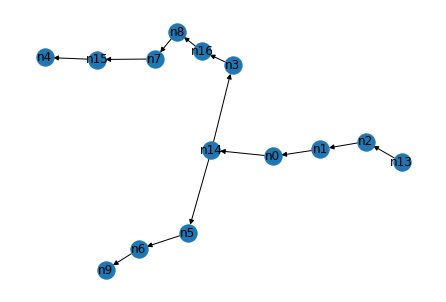

In [7]:
frontend_node = [n for n in graph.nodes.data() if n[1]["id"] == "front-end"][0]
anomaly_graph0 = nx.dfs_tree(graph, frontend_node[0])
nx.draw(anomaly_graph0, with_labels=True)

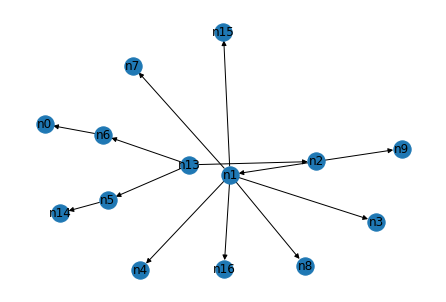

In [8]:
anomaly_graph0 = nx.bfs_tree(graph, frontend_node[0])
nx.draw(anomaly_graph0, with_labels=True)

In [9]:
list(nx.dfs_successors(graph, frontend_node[0]))

['n13', 'n2', 'n1', 'n0', 'n14', 'n3', 'n16', 'n8', 'n7', 'n15', 'n5', 'n6']

In [10]:
list(nx.bfs_successors(graph, frontend_node[0]))

[('n13', ['n2', 'n5', 'n6']),
 ('n2', ['n1', 'n9']),
 ('n5', ['n14']),
 ('n6', ['n0']),
 ('n1', ['n16', 'n3', 'n4', 'n7', 'n8', 'n15'])]

In [67]:
MAXLAG = 2
DATETIME_FORMAT = "%m/%d/%Y %H:%M"

def propagation_timestamp_next_node(current_node, neighbor, nodes_to_visit):
    if neighbor in nodes_to_visit:
        return None
    #print(graph.nodes[neighbor])
    neighbor_data = graph.nodes[neighbor]
    if not neighbor_data.get("anomaly"):
        return None
    current_timestamp = G.nodes[current_node]["propagation_timestamp"]
    current_timestamp = datetime.strptime(current_timestamp, DATETIME_FORMAT)
    neighbor_anomaly_timestamps = np.array([datetime.strptime(timestamp, DATETIME_FORMAT) for timestamp in neighbor_data["anomaly_timestamps"]])
    max_propagation_timestamp = None
    
    time_diff = neighbor_anomaly_timestamps - current_timestamp
    propagation_timestamps = neighbor_anomaly_timestamps[np.logical_and((timedelta(minutes=0) <= time_diff), (time_diff <= timedelta(minutes=MAXLAG)))]
    if not len(propagation_timestamps):
        return None
    max_propagation_timestamp = datetime.strftime(np.max(propagation_timestamps), DATETIME_FORMAT)
    return max_propagation_timestamp

Next node
[('n5', '03/02/2022 13:23'), ('n6', '03/02/2022 13:23')]
Next node
[('n9', '03/02/2022 13:23')]
Next node
Next node


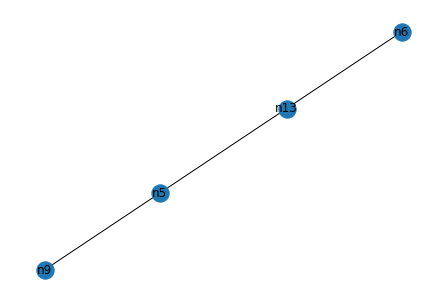

In [69]:
G=nx.Graph()
G.add_node(frontend_node[0], propagation_timestamp='3/2/2022 13:22')
nodes_to_visit = [frontend_node[0]]
for node in nodes_to_visit:
    potential_next_nodes = []
    print("Next node")
    for n in list(graph.neighbors(node)):
        propagation_timestamp = propagation_timestamp_next_node(node, n, nodes_to_visit)
        if propagation_timestamp is not None:
            potential_next_nodes.append((n, propagation_timestamp))
    
    if len(potential_next_nodes) > 0:
        if np.random.choice([0, 1]):
            # bfs way
            next_nodes = potential_next_nodes
        else:
            # dfs way
            next_nodes = [potential_next_nodes[np.random.choice(len(potential_next_nodes))]]
            
        nodes_to_visit += [n for n, timestamp in next_nodes]
        for next_node, p_timestamp in next_nodes:
            G.add_node(next_node, propagation_timestamp=p_timestamp)
            G.add_edge(node, next_node, propagation_timestamp=p_timestamp)
        print(next_nodes)
nx.draw(G, with_labels=True)

### Sample subgraph with dfs/bfs tree combination

In [81]:
def sample_subgraph(super_graph, start_node: str, bfs_prob=0.5, max_nodes=None, random_seed=42) -> nx.DiGraph():
    np.random.seed(random_seed)
    G=nx.DiGraph()
    G.add_node(start_node)
    nodes_to_visit = [start_node]
    if max_nodes is None:
        max_nodes = len(super_graph.nodes())
    assert max_nodes>0, 'enter positive max_nodes'
    for node in nodes_to_visit:
        potential_next_nodes = []
        potential_next_nodes = [n for n in list(super_graph.neighbors(node)) if not n in nodes_to_visit]
        if len(potential_next_nodes) > 0:
            if np.random.choice([0, 1], p=[1-bfs_prob, bfs_prob]):
                # bfs way
                next_nodes = potential_next_nodes
            else:
                # dfs way
                next_nodes = [potential_next_nodes[np.random.choice(len(potential_next_nodes))]]
            
            num_nodes_to_add = np.minimum(max_nodes-len(G.nodes()), len(next_nodes))
            next_nodes = next_nodes[:num_nodes_to_add]
            nodes_to_visit += next_nodes
            for next_node in next_nodes:
                G.add_node(next_node)
                G.add_edge(node, next_node)
        if len(G.nodes())>=max_nodes:
            return G
    return G


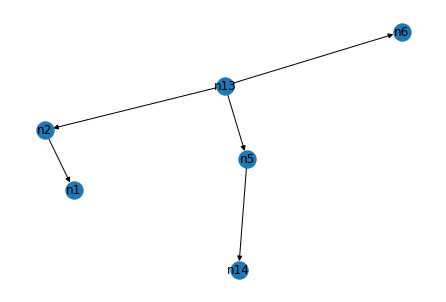

In [94]:
subgraph = sample_subgraph(graph, frontend_node[0], bfs_prob=0.5, max_nodes=6, random_seed=111)
nx.draw(subgraph, with_labels=True)

In [102]:
list(subgraph.edges('n13'))

[('n13', 'n2'), ('n13', 'n5'), ('n13', 'n6')]

In [ ]:
def add_timesteps_to_graph(subgraph, start_node) -> nx.DiGraph():
    timestep = 0
    edge_pool = {edge:1 for edge in list(subgraph.edges(start_node))}

    while edge_pool:
        edge_to_sample = np.random.choice(edge_pool.keys(),p=np.array(edge_pool.values())/np.sum(edge_pool.values()))
        del edge_pool[edge_to_sample]
        nx.set_edge_attributes(subgraph, {edge_to_sample: {"timestep": timestep}})
        for key in edge_pool.keys():
            edge_pool[key]+=1
        edge_pool.update({edge:1 for edge in list(subgraph.edges(edge_to_sample[1])) if edge not in edge_pool.keys()})
    

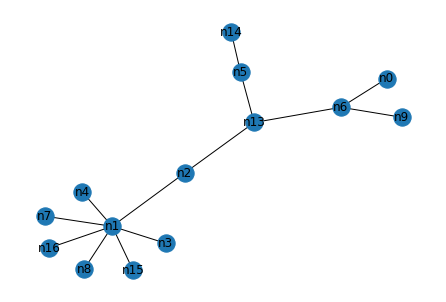

In [70]:
MAXLAG = 2

G=nx.Graph()
G.add_node(frontend_node[0])
# idea for timestep sampling
time=0
nodes_to_visit = [frontend_node[0]]
for node in nodes_to_visit:
    potential_next_nodes = []
    potential_next_nodes = [n for n in list(graph.neighbors(node)) if not n in nodes_to_visit]
    
    if len(potential_next_nodes) > 0:
        if np.random.choice([0, 1]):
            # bfs way
            next_nodes = potential_next_nodes
        else:
            # dfs way
            next_nodes = [potential_next_nodes[np.random.choice(len(potential_next_nodes))]]
            
        nodes_to_visit += next_nodes
        for next_node in next_nodes:
            G.add_node(next_node)
            G.add_edge(node, next_node, timestamp=time)
        time +=1
nx.draw(G, with_labels=True)

In [71]:
edge_df = nx.to_pandas_edgelist(G)
edge_df.columns = ['i','j','t']
edge_df = edge_df.replace(to_replace=r'^n', value='', regex=True)
edge_df = edge_df.apply(pd.to_numeric)
edge_df

,i,j,t
0,13,2,0
1,13,5,0
2,13,6,0
3,2,1,1
4,5,14,2
5,6,0,3
6,6,9,3
7,1,16,4
8,1,3,4
9,1,4,4


In [72]:
add_edges = []
for i in edge_df.index:
    row = edge_df.iloc[i]
    times_to_add = np.arange(row["t"], time)
    for t_to_add in times_to_add:
        add_edges.append([row["i"], row["j"], t_to_add])

In [73]:
fill_edges = pd.DataFrame(add_edges, columns=edge_df.columns)
fill_edges

,i,j,t
0,13,2,0
1,13,2,1
2,13,2,2
3,13,2,3
4,13,2,4
5,13,5,0
6,13,5,1
7,13,5,2
8,13,5,3
9,13,5,4


In [35]:
#%pip install teneto

In [59]:
from teneto import TemporalNetwork
import teneto
tnet = TemporalNetwork(from_df=fill_edges)

In [60]:
tnet.network

,i,j,t
0,13,2,0
1,13,2,1
2,13,2,2
3,13,2,3
4,13,2,4
5,13,5,0
6,13,5,1
7,13,5,2
8,13,5,3
9,13,5,4


In [ ]:
closeness_centrality =  teneto.networkmeasures.temporal_closeness_centrality(tnet=tnet)

In [ ]:
existing_temporal_paths = teneto.networkmeasures.shortest_temporal_path(tnet, minimise='temporal_distance').dropna()

In [64]:
pd.Series(teneto.networkmeasures.temporal_degree_centrality(tnet=tnet))

0      0.0
1      6.0
2      8.0
3      0.0
4      0.0
5      3.0
6      2.0
7      0.0
8      0.0
9      0.0
10     0.0
11     0.0
12     0.0
13    15.0
14     0.0
15     0.0
16     0.0
dtype: float64

In [119]:
print(frontend_node[1]["anomaly_timestamps"])

['3/2/2022 11:50', '3/2/2022 13:22', '3/2/2022 15:47', '3/2/2022 17:48']


In [67]:
print([graph.nodes[node] for node in list(graph.neighbors(frontend_node[0]))])

[{'labels': ':Node', 'id': 'user-db'}, {'labels': ':Node', 'id': 'orders-db', 'anomaly': True, 'anomaly_timestamps': ['3/2/2022;12:13', '3/2/2022;13:22', '3/2/2022;13:23', '3/2/2022;17:39', '3/2/2022;19:41']}, {'labels': ':Node', 'id': 'carts-db', 'anomaly': True, 'anomaly_timestamps': ['3/2/2022;13:22', '3/2/2022;13:23']}]
